In [ ]:
### This is Tutorial Notebook for those who want to explore StyleGAN Pytorch

In [1]:
#Import Libraries
import os
import torch
import numpy as np
from PIL import Image

import stylegan2
from stylegan2 import utils

In [2]:
def generate_images( G, seeds, truncation_psi):
    
    def get_batch(seeds):
        latents = []
        labels = []
        noise_tensors = [[] for _ in noise_reference]
        
        for seed in seeds:
            rnd = np.random.RandomState(seed)
            latents.append(torch.from_numpy(rnd.randn(latent_size)))
            for i, ref in enumerate(noise_reference):
                noise_tensors[i].append(torch.from_numpy(rnd.randn(*ref.size()[1:])))
            if label_size:
                labels.append(torch.tensor([rnd.randint(0, label_size)]))
                
        latents = torch.stack(latents, dim=0).to(device=device, dtype=torch.float32)
        if labels:
            labels = torch.cat(labels, dim=0).to(device=device, dtype=torch.int64)
        else:
            labels = None
            
        noise_tensors = [
            torch.stack(noise, dim=0).to(device=device, dtype=torch.float32)
            for noise in noise_tensors
        ]
        return latents, labels, noise_tensors
    
    latent_size, label_size = G.latent_size, G.label_size
    device = torch.device('cpu')
    G.to(device)
    if truncation_psi != 1:
        G.set_truncation(truncation_psi=truncation_psi)
    noise_reference = G.static_noise()

    progress = utils.ProgressWriter(len(seeds))
    progress.write('Generating images...', step=False)

    output_img_list = []
    for i in range(0, len(seeds), 1):
        latents, labels, noise_tensors = get_batch(seeds[i: i + 1])
        if noise_tensors is not None:
            G.static_noise(noise_tensors=noise_tensors)
        with torch.no_grad():
            generated = G(latents, labels=labels)
        images = utils.tensor_to_PIL(
            generated, pixel_min=-1, pixel_max=1)
        for seed, img in zip(seeds[i: i + 1], images):
            output_img_list.append(img)
            progress.step()

    progress.write('Done!', step=False)
    progress.close()
    
    return output_img_list

In [3]:
from math import ceil

def createImageGrid(images, scale=0.25, rows=1):
   w,h = images[0].size
   w = int(w*scale)
   h = int(h*scale)
   height = rows*h
   cols = ceil(len(images) / rows)
   width = cols*w
   canvas = Image.new('RGBA', (width,height), 'white')
   for i,img in enumerate(images):
     img = img.resize((w,h), Image.ANTIALIAS)
     canvas.paste(img, (w*(i % cols), h*(i // cols))) 
   return canvas

  0%|          | 0/5 [00:00<?, ?it/s]

Done!

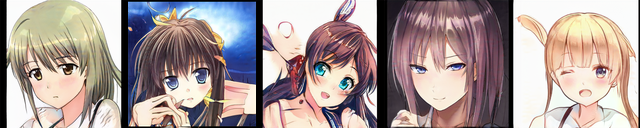

In [4]:
G = stylegan2.models.load("pretrained_model/Gs.pth")
seeds = np.random.randint(10000000, size=5)
images = generate_images(G,seeds, 1)
createImageGrid(images)

In [5]:
def style_mixing_example( G, row_seeds, col_seeds, truncation_psi):
    device = torch.device('cpu')
    G.to(device)
    G.static_noise()
    latent_size, label_size = G.latent_size, G.label_size
    G_mapping, G_synthesis = G.G_mapping, G.G_synthesis

    all_seeds = list(set(row_seeds + col_seeds))
    all_z = torch.stack([torch.from_numpy(np.random.RandomState(seed).randn(latent_size)) for seed in all_seeds])
    all_z = all_z.to(device=device, dtype=torch.float32)
    print("Z-size:{}".format(all_z.size()))
    
    if label_size:
        labels = torch.zeros(len(all_z), dtype=torch.int64, device=device)
    else:
        labels = None

    print('Generating disentangled latents...')
    with torch.no_grad():
        all_w = G_mapping(latents=all_z, labels=labels)

    all_w = all_w.unsqueeze(1).repeat(1, len(G_synthesis), 1)
    print("W-size:{}".format(all_w.size()))

    w_avg = G.dlatent_avg

    if truncation_psi != 1:
        all_w = w_avg + truncation_psi * (all_w - w_avg)

    w_dict = {seed: w for seed, w in zip(all_seeds, all_w)}

    all_images = []

    progress = utils.ProgressWriter(len(all_w))
    progress.write('Generating images...', step=False)

    with torch.no_grad():
        for w in all_w:
            all_images.append(G_synthesis(w.unsqueeze(0)))
            progress.step()

    progress.write('Done!', step=False)
    progress.close()

    all_images = torch.cat(all_images, dim=0)

    image_dict = {(seed, seed): image for seed, image in zip(all_seeds, all_images)}

    progress = utils.ProgressWriter(len(row_seeds) * len(col_seeds))
    progress.write('Generating style-mixed images...', step=False)

    for row_seed in row_seeds:
        for col_seed in col_seeds:
            w = w_dict[row_seed].clone()
            w[0] = w_dict[col_seed][0]
            with torch.no_grad():
                image_dict[(row_seed, col_seed)] = G_synthesis(w.unsqueeze(0)).squeeze(0)
            progress.step()

    progress.write('Done!', step=False)
    progress.close()

    progress = utils.ProgressWriter(len(image_dict))
    progress.write('Saving images...', step=False)

    for (row_seed, col_seed), image in list(image_dict.items()):
        image = utils.tensor_to_PIL(
            image, pixel_min=-1, pixel_max=1)
        image_dict[(row_seed, col_seed)] = image
        progress.step()

    progress.write('Done!', step=False)
    progress.close()

    print('\n\nSaving style-mixed grid...')
    H, W = all_images.size()[2:]
    canvas = Image.new(
        'RGB', (W * (len(col_seeds) + 1), H * (len(row_seeds) + 1)), 'black')
    for row_idx, row_seed in enumerate([None] + row_seeds):
        for col_idx, col_seed in enumerate([None] + col_seeds):
            if row_seed is None and col_seed is None:
                continue
            key = (row_seed, col_seed)
            if row_seed is None:
                key = (col_seed, col_seed)
            if col_seed is None:
                key = (row_seed, row_seed)
            canvas.paste(image_dict[key], (W * col_idx, H * row_idx))
    print('Done!')
    return canvas

Z-size:torch.Size([4, 512])
Generating disentangled latents...
W-size:torch.Size([4, 16, 512])


  0%|          | 0/4 [00:00<?, ?it/s]

Done!

  0%|          | 0/4 [00:00<?, ?it/s]

Done!

  0%|          | 0/8 [00:00<?, ?it/s]

Done!



Saving style-mixed grid...
Done!


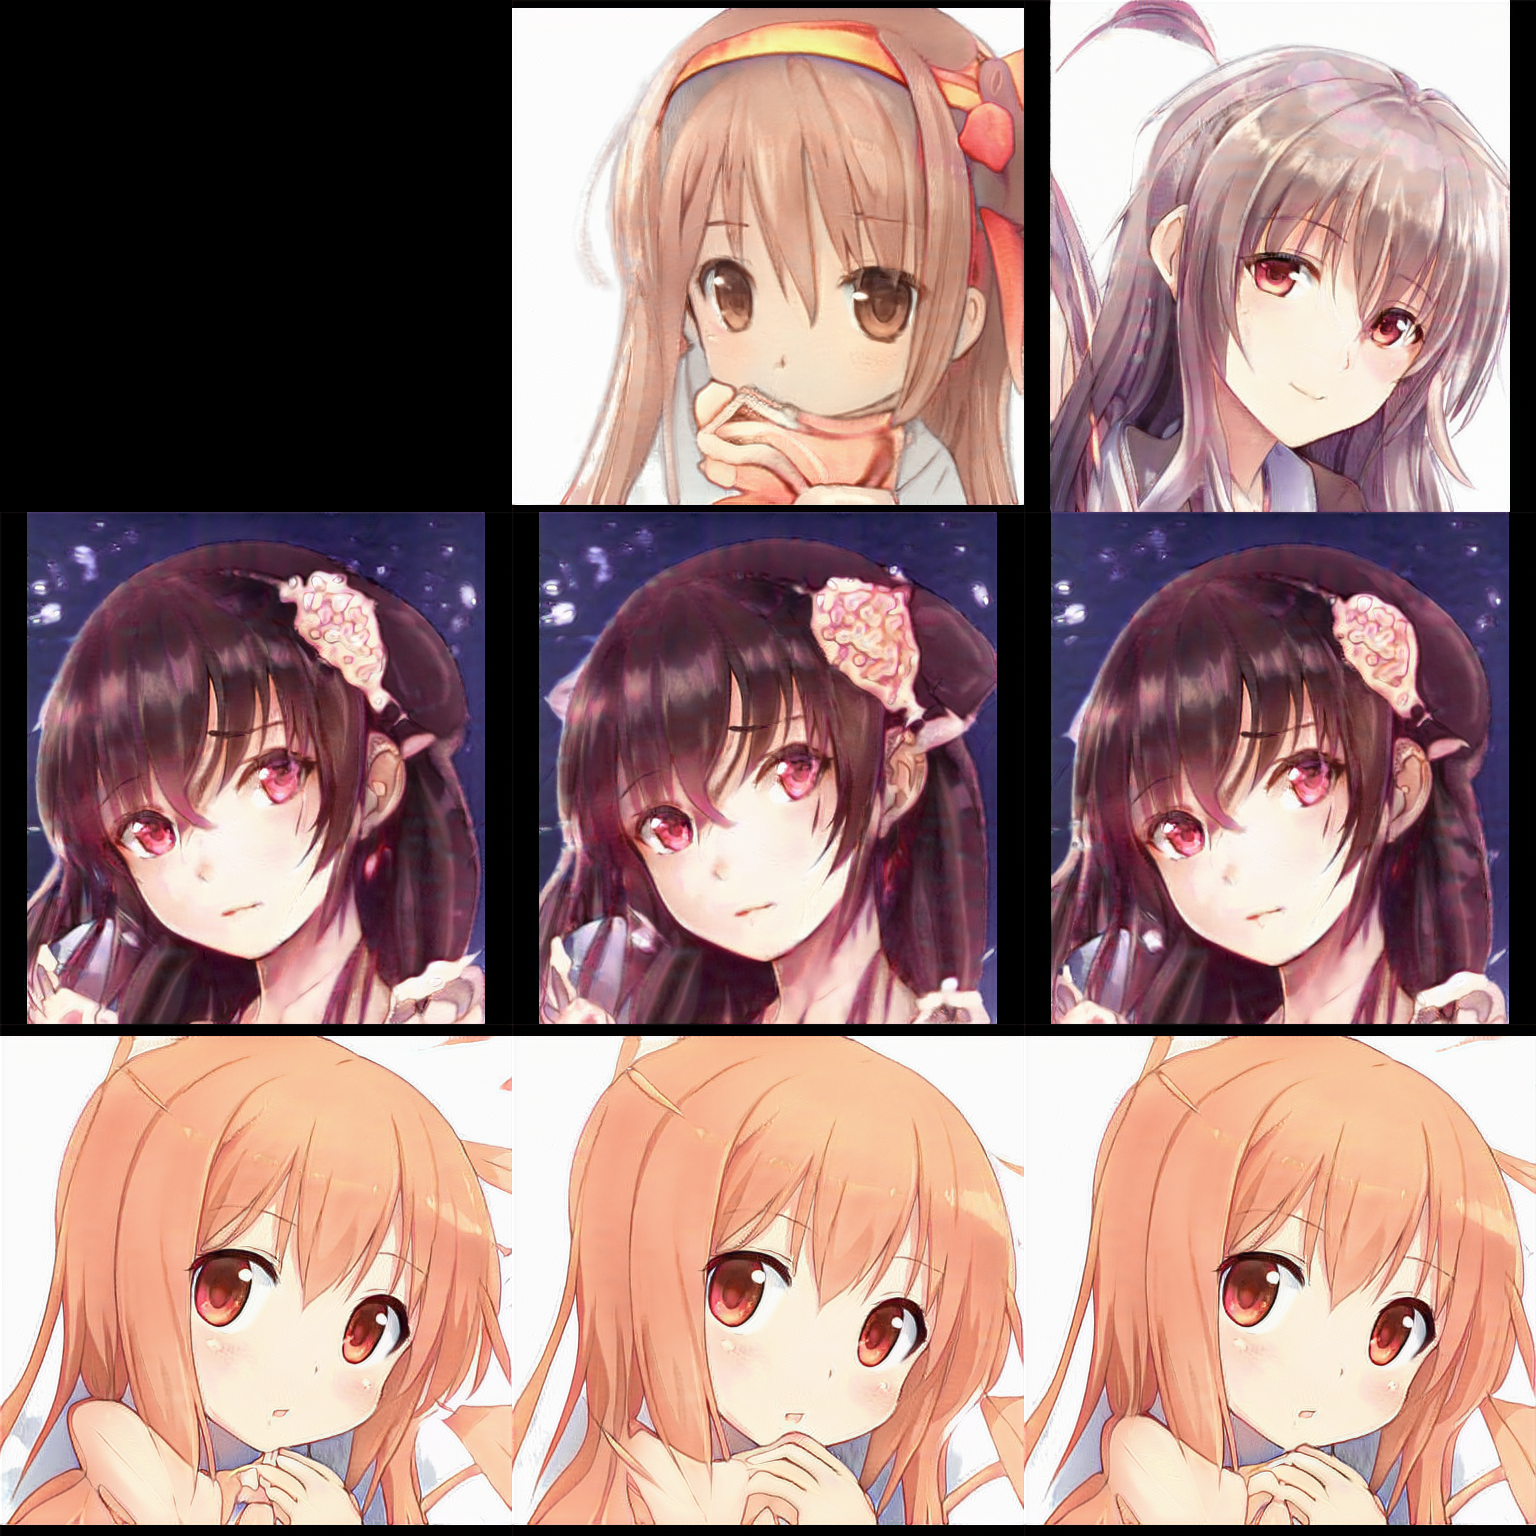

In [6]:
style_mixing_example(G,[4000,404],[1000,2000],0.8)

In [7]:
def interpolation_example( G, first_seed, second_seed, truncation_psi, steps):
    device = torch.device('cpu')
    G.to(device)
    G.static_noise()
    latent_size, label_size = G.latent_size, G.label_size
    G_mapping, G_synthesis = G.G_mapping, G.G_synthesis
    
    zs1 = torch.from_numpy(np.random.RandomState(first_seed).randn(latent_size));
    zs2 = torch.from_numpy(np.random.RandomState(second_seed).randn(latent_size));
    
    all_seeds = []
    
    for index in range(steps):
        fraction = index/float(steps) 
        all_seeds.append(zs1*fraction + zs2*(1-fraction))
        
    all_z = torch.stack([seed for seed in all_seeds])
    all_z = all_z.to(device=device, dtype=torch.float32)
    print("Z-size:{}".format(all_z.size()))
    
    if label_size:
        labels = torch.zeros(len(all_z), dtype=torch.int64, device=device)
    else:
        labels = None

    print('Generating disentangled latents...')
    with torch.no_grad():
        all_w = G_mapping(latents=all_z, labels=labels)

    all_w = all_w.unsqueeze(1).repeat(1, len(G_synthesis), 1)
    print("W-size:{}".format(all_w.size()))

    w_avg = G.dlatent_avg

    if truncation_psi != 1:
        all_w = w_avg + truncation_psi * (all_w - w_avg)

    w_dict = {seed: w for seed, w in zip(all_seeds, all_w)}

    all_images = []

    progress = utils.ProgressWriter(len(all_w))
    progress.write('Generating images...', step=False)

    with torch.no_grad():
        for w in all_w:
            all_images.extend(G_synthesis(w.unsqueeze(0)))
            progress.step()

    progress.write('Done!', step=False)
    progress.close()

    output_images = []
    for index in range(steps):
        image = utils.tensor_to_PIL(all_images[index], pixel_min=-1, pixel_max=1)
        output_images.append(image)
    return output_images
        

In [8]:
output_images = interpolation_example(G,np.random.randint(10000000),np.random.randint(10000000),0.8,7)

Z-size:torch.Size([7, 512])
Generating disentangled latents...
W-size:torch.Size([7, 16, 512])


  0%|          | 0/7 [00:00<?, ?it/s]

Done!

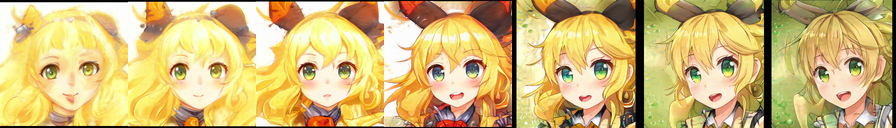

In [9]:
createImageGrid(output_images)

In [10]:
import pickle
with open("pretrained_model/modded_dlatents/tag_dirs_cont.pkl", "rb") as f:
    tag_directions = pickle.load(f)

tag_len = {}
for tag in tag_directions:
    tag_len[tag] = np.linalg.norm(tag_directions[tag].flatten())

In [11]:
import copy
def latent_direction_example( G, input_seed, truncation_psi, steps):
    device = torch.device('cpu')
    G.to(device)
    G.static_noise()
    latent_size, label_size = G.latent_size, G.label_size
    G_mapping, G_synthesis = G.G_mapping, G.G_synthesis

    all_z = torch.stack([torch.from_numpy(np.random.RandomState(input_seed).randn(latent_size))])
    all_z = all_z.to(device=device, dtype=torch.float32)
    print("Z-size:{}".format(all_z.size()))
    
    if label_size:
        labels = torch.zeros(len(all_z), dtype=torch.int64, device=device)
    else:
        labels = None

    print('Generating disentangled latents...')
    with torch.no_grad():
        all_w = G_mapping(latents=all_z, labels=labels)

    all_w = all_w.unsqueeze(1).repeat(1, len(G_synthesis), 1)
    print("W-size:{}".format(all_w.size()))

    w_avg = G.dlatent_avg

    if truncation_psi != 1:
        all_w = w_avg + truncation_psi * (all_w - w_avg)
        
    dlatents_mod_array = []
    for index in range(steps):
        dlatents_mod = copy.deepcopy(all_w[0])
        dlatents_mod += tag_directions["pink_hair"] * index / tag_len["pink_hair"] * 25.0
        dlatents_mod_array.append(dlatents_mod)
        
    new_w = torch.stack([dlatent for dlatent in dlatents_mod_array])
    print("new-W-size:{}".format(new_w.size()))

    all_images = []

    progress = utils.ProgressWriter(len(new_w))
    progress.write('Generating images...', step=False)

    with torch.no_grad():
        for w in new_w:
            all_images.extend(G_synthesis(w.unsqueeze(0)))
            progress.step()

    progress.write('Done!', step=False)
    progress.close()

    output_images = []
    for index in range(steps):
        image = utils.tensor_to_PIL(all_images[index], pixel_min=-1, pixel_max=1)
        output_images.append(image)
    return output_images

In [12]:
output_images = latent_direction_example(G,np.random.randint(10000000),0.5,5)

Z-size:torch.Size([1, 512])
Generating disentangled latents...
W-size:torch.Size([1, 16, 512])
new-W-size:torch.Size([5, 16, 512])


  0%|          | 0/5 [00:00<?, ?it/s]

Done!

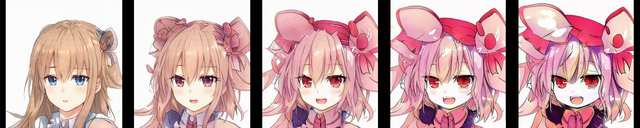

In [13]:
createImageGrid(output_images)

In [14]:
import copy
def latent_direction_Interface( G, zspace_input, truncation_psi, input_param):
    device = torch.device('cpu')
    G.to(device)
    G.static_noise()
    latent_size, label_size = G.latent_size, G.label_size
    G_mapping, G_synthesis = G.G_mapping, G.G_synthesis

    zspace_input = zspace_input.to(device=device, dtype=torch.float32)
    print("Z-size:{}".format(zspace_input.size()))
    
    if label_size:
        labels = torch.zeros(len(zspace_input), dtype=torch.int64, device=device)
    else:
        labels = None

    print('Generating disentangled latents...')
    with torch.no_grad():
        all_w = G_mapping(latents=zspace_input, labels=labels)

    all_w = all_w.unsqueeze(1).repeat(1, len(G_synthesis), 1)
    print("W-size:{}".format(all_w.size()))

    w_avg = G.dlatent_avg

    if truncation_psi != 1:
        all_w = w_avg + truncation_psi * (all_w - w_avg)
        
    dlatents_mod = copy.deepcopy(all_w[0])
    
    if(len(input_param)>0):
        for param_name, param_value in input_param.items():
            dlatents_mod += tag_directions[param_name] * param_value / tag_len[param_name] * 25.0

    progress = utils.ProgressWriter(1)
    progress.write('Generating images...', step=False)

    with torch.no_grad():
            tensor_image = G_synthesis(dlatents_mod.unsqueeze(0))
            progress.step()

    progress.write('Done!', step=False)
    progress.close()

    output_image = utils.tensor_to_PIL(tensor_image, pixel_min=-1, pixel_max=1)
    
    return output_image

In [30]:
input_seed = np.random.randint(10000000)
input_zs = torch.stack([torch.from_numpy(np.random.RandomState(input_seed).randn(G.latent_size))])

Z-size:torch.Size([1, 512])
Generating disentangled latents...
W-size:torch.Size([1, 16, 512])


  0%|          | 0/1 [00:00<?, ?it/s]

Done!

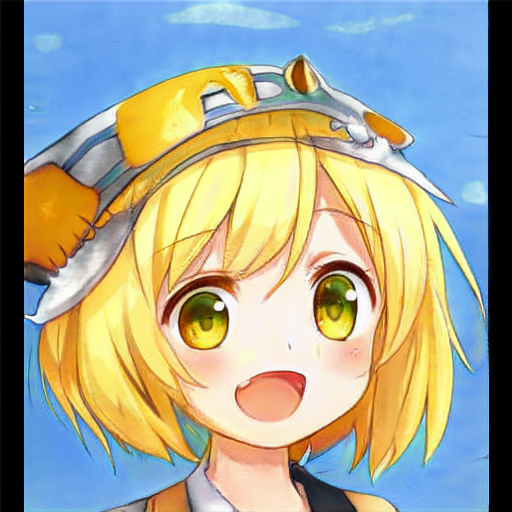

In [33]:
output_images = latent_direction_Interface( G, input_zs, 0.9, {"blonde_hair":0.75,"open_mouth":0.25})
output_images[0]